In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from torchvision.io import read_image
import os
import glob
import random
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import seaborn as sn
writer = SummaryWriter('runs/CloudNetGCD')

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda', index=2)

In [5]:
""" Convolutional neural network model """
class CloudNet(nn.Module):
    def __init__(self):
        super(CloudNet, self).__init__()
        self.pool = nn.MaxPool2d(3, stride=2)
        self.conv1 = nn.Conv2d(3, 96, 11, stride=4, bias=False)
        self.b1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 256, 5, padding=2, bias=False)
        self.b2 = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 384, 3, padding=1, bias=False)
        self.b3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 256, 3, padding=1, bias=False)
        self.b4 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 6 * 6, 9216)
        self.fc2 = nn.Linear(9216, 4096)
        self.fc3 = nn.Linear(4096, 7)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.b1(self.conv1(x))))
        x = self.pool(F.relu(self.b2(self.conv2(x))))
        x = F.relu(self.b3(self.conv3(x)))
        x = self.pool(F.relu(self.b4(self.conv4(x))))
        x = x.view(-1, 256 * 6 * 6)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [6]:
class GCD(Dataset):
    """GCD Dataset."""
    def __init__(self, transform=None, image_size=227, modo='', test_size=12, random_crop=False, random_flip=False):
        classes = [(0, 'cumulus'),
                  (1, 'altocumulus'),
                  (2, 'cirrus'),
                  (3, 'clearsky'),
                  (4, 'stratocumulus'),
                  (5, 'cumulonimbus'),
                  (6, 'mixed')
                  ] 
        image_paths = ['/data/mandonaire/GCD/{}/1_cumulus',
                      '/data/mandonaire/GCD/{}/2_altocumulus',
                      '/data/mandonaire/GCD/{}/3_cirrus',
                      '/data/mandonaire/GCD/{}/4_clearsky',
                      '/data/mandonaire/GCD/{}/5_stratocumulus',
                      '/data/mandonaire/GCD/{}/6_cumulonimbus',
                      '/data/mandonaire/GCD/{}/7_mixed'
                      ]
        
        # Create one-hot label encoding
        # self.label_binarizer = LabelBinarizer().fit(classes)
        self.image_paths = image_paths
        self.classes = classes
        self.transform = transform
        self.images = []
        self.labels = []
        self.n_labels = []
        self.aug_images = []
        self.aug_labels = []
        self.aug_n_labels = []
        self.mean_r = 0
        self.mean_g = 0
        self.mean_b = 0
        self.image_size = image_size
        self.random_crop = random_crop
        self.random_flip = random_flip
        
        if modo == 'train':
            transform = transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(image_size),
                transforms.ToTensor(),
                ]
            )
            for (n_label, label), path in zip(classes, image_paths):
                for file in glob.glob(os.path.join(path.format(modo), '*')):
                    self.labels.append(label)
                    self.n_labels.append(n_label)
                    image = read_image(file)
                    if random_crop or random_flip:
                        new_image = self.augment_img(image)
                        self.aug_images.append(new_image)
                        self.aug_labels.append(label)
                        self.aug_n_labels.append(n_label)
                    image = transform(image)
                    self.images.append(image)
            self.images = torch.stack(self.images)
            # self.mean_r, self.mean_g, self.mean_b = torch.mean(self.images[:, 0, :, :] * 1.0), torch.mean(self.images[:, 1, :, :] * 1.0), torch.mean(self.images[:, 2, :, :] * 1.0)
            # self.images[:, 0, :, :] = self.images[:, 0, :, :] - self.mean_r
            # self.images[:, 1, :, :] = self.images[:, 1, :, :] - self.mean_g
            # self.images[:, 2, :, :] = self.images[:, 2, :, :] - self.mean_g
            # self.std_r, self.std_g, self.std_b = torch.std(self.images[:, 0, :, :] * 1.0), torch.std(self.images[:, 1, :, :] * 1.0), torch.std(self.images[:, 2, :, :] * 1.0)
            # self.images[:, 0, :, :] = self.images[:, 0, :, :] / self.std_r
            # self.images[:, 1, :, :] = self.images[:, 1, :, :] / self.std_g
            # self.images[:, 2, :, :] = self.images[:, 2, :, :] / self.std_b
            
            if random_crop or random_flip:
                self.labels = self.labels + self.aug_labels
                self.n_labels = self.n_labels + self.aug_n_labels
                self.aug_images = torch.stack(self.aug_images)
                # self.aug_images[:, 0, :, :] = self.aug_images[:, 0, :, :] - self.mean_r
                # self.aug_images[:, 1, :, :] = self.aug_images[:, 1, :, :] - self.mean_g
                # self.aug_images[:, 2, :, :] = self.aug_images[:, 2, :, :] - self.mean_g
                # self.aug_images[:, 0, :, :] = self.aug_images[:, 0, :, :] / self.std_r
                # self.aug_images[:, 1, :, :] = self.aug_images[:, 1, :, :] / self.std_g
                # self.aug_images[:, 2, :, :] = self.aug_images[:, 2, :, :] / self.std_b
                self.images = torch.cat([self.images, self.aug_images])
        elif modo == 'test':
            for (n_label, label), path in zip(classes, image_paths):
                for file in glob.glob(os.path.join(path.format(modo), '*')):
                    self.labels.append(label)
                    self.n_labels.append(n_label)
                    image = read_image(file)
                    self.images.append(image)
                        
            self.images = torch.stack(self.images)
        
    def get_mean(self):
        return [self.mean_r, self.mean_g, self.mean_b]
    
    def get_std(self):
        return [self.std_r, self.std_g, self.std_b]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.n_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def augment_img(self, image):
        if self.random_crop and self.random_flip:
            transform = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize(self.image_size),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomResizedCrop(size=(self.image_size, self.image_size), scale=(0.3, 0.65)),
                                            transforms.ToTensor()
                                           ])
        elif self.random_crop and not self.random_flip:
            transform = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize(self.image_size),
                                            transforms.RandomResizedCrop(size=(self.image_size, self.image_size), scale=(0.3, 0.65)),
                                            transforms.ToTensor()
                                           ])
        elif not self.random_crop and self.random_flip:
            transform = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Resize(self.image_size),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.ToTensor()
                                           ])
        new_image = transform(image)
        return new_image
        

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=1.0)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, mean=0.0, std=1.0)
        torch.nn.init.constant_(m.bias, 0)

In [8]:
image_size = 227
train_data = GCD(transform=None, modo='train', random_crop=False, random_flip=False)
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
     # transforms.Normalize(
     #     mean = train_data.get_mean(),
     #     std = train_data.get_std())
    ]
)
test_data = GCD(transform=transform_test, modo='test')

In [9]:
batch_size_train = 32
batch_size_test = 12
len(test_data)

9000

In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size_test, shuffle=True)

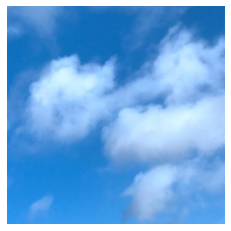

torch.Size([3, 227, 227])

In [11]:
plt.imshow(train_data[600][0].permute(1, 2, 0)) # SK H, W, C Pytorch  C, H, W
plt.axis('off')
plt.show()
train_data[600][0].shape

In [12]:
n_total_steps = len(train_loader)
n_total_steps

313

In [13]:
learning_rate = 0.001
num_epochs = 300
reduce_factor = 10
print_epochs = 100
reduce_epochs = 5000
running_loss = 0.0
running_correct = 0
examples = iter(test_loader)
sample_data, sample_labels = examples.next()
sample_data = sample_data.to(device)
model = CloudNet().to(device)
model = model.apply(weights_init)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
writer.add_graph(model, sample_data)

In [ ]:
num_epochs = 1000
batch_size = batch_size_train
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
    
    if (epoch+1) % 250 == 0:
        for g in optimizer.param_groups:
            g['lr'] = g['lr']/10

print('Finished Training')
PATH = './cloudNetGCD.pth'
torch.save(model.state_dict(), PATH)

Epoch [1/1000], Step [100/313], Loss: 1.7009
Epoch [1/1000], Step [200/313], Loss: 1.4009
Epoch [1/1000], Step [300/313], Loss: 1.1340
Epoch [2/1000], Step [100/313], Loss: 1.0157
Epoch [2/1000], Step [200/313], Loss: 0.8307
Epoch [2/1000], Step [300/313], Loss: 0.8964
Epoch [3/1000], Step [100/313], Loss: 0.8995
Epoch [3/1000], Step [200/313], Loss: 1.2571
Epoch [3/1000], Step [300/313], Loss: 0.9582
Epoch [4/1000], Step [100/313], Loss: 1.0415
Epoch [4/1000], Step [200/313], Loss: 0.9482
Epoch [4/1000], Step [300/313], Loss: 1.0233
Epoch [5/1000], Step [100/313], Loss: 1.1083
Epoch [5/1000], Step [200/313], Loss: 0.6360
Epoch [5/1000], Step [300/313], Loss: 0.8842
Epoch [6/1000], Step [100/313], Loss: 0.9820
Epoch [6/1000], Step [200/313], Loss: 0.7263
Epoch [6/1000], Step [300/313], Loss: 0.7739
Epoch [7/1000], Step [100/313], Loss: 0.8849
Epoch [7/1000], Step [200/313], Loss: 0.8562
Epoch [7/1000], Step [300/313], Loss: 0.7053
Epoch [8/1000], Step [100/313], Loss: 0.6910
Epoch [8/1

In [ ]:
classes = train_data.classes
matrix = np.zeros((len(classes), len(classes)))
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size_test):
            label = labels[i]
            pred = predicted[i]
            matrix[label][pred] += 1
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(len(classes)):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        matrix[i] = matrix[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

In [ ]:
df_cm = pd.DataFrame(matrix, index = train_data.classes,
                  columns = train_data.classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)